In [111]:
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from typing import TypedDict, Literal, Annotated
from dotenv import load_dotenv
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field

In [112]:
load_dotenv()
generation_model = ChatGroq(model= "openai/gpt-oss-120b")
evaluating_model = ChatGroq(model= "deepseek-r1-distill-llama-70b")
optimizing_model = ChatGroq(model = "gemma2-9b-it")

In [113]:
# Creating a State
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

In [114]:
# Creating for structure o/p
class EvaluateSchema(BaseModel):
    evaluation: Literal["approved", "needs_improvement"]
    feedback : str

In [115]:
structured_evaluate_model = evaluating_model.with_structured_output(EvaluateSchema)


In [116]:
# Creating fucntions
def generate_tweet(state: TweetState)-> TweetState:
    message = [
        SystemMessage(content="You are a clever and funny Twitter/x influencer"),
        HumanMessage(content=f"""
    You are an expert social media writer. Write a highly engaging tweet more than 300 char .
    Tone: [humorous, funny]
    Topic: {state["topic"]}
    Make it clear, catchy, and easy to read.
    Optionally include relevant hashtags or emojis if they enhance engagement (but don’t overuse).
    Ensure it feels like a natural tweet, not an ad.
    """)
    ]
    
    response = generation_model.invoke(message).content
    return {"tweet": response}

In [117]:
def evaluate_tweet(state: TweetState) -> TweetState:
    message = [
        SystemMessage(content="You are a strict social media content evaluator. Your job is to enforce Twitter/X best practices."),
        HumanMessage(content=f"""
    Evaluate the following tweet against these rules. 
    Be objective, strict, and provide both pass/fail checks and improvement notes.

    **Rules to check:**
    1. Character Limit – Must be ≤ 280 characters.  
    2. Format – Avoid Q&A style (no "Q:" / "A:" or similar structures).  
    3. Clarity – Must be clear and understandable at first glance.  
    4. Engagement – Should be engaging, not bland or generic.  
    5. Tone – Must match the chosen tone (witty, professional, motivational, educational, casual, or humorous).  
    6. Hashtags & Emojis – Allowed only if relevant, never excessive.  
    7. Ads/Spam – Must not sound like an advertisement or spam.  
    8. Originality – Should not feel cliché or overused.  

    **Output format (JSON):**
    {{
      "character_count": <number>,
      "character_limit_ok": <true/false>,
      "q_a_format_detected": <true/false>,
      "clarity_score": <1-10>,
      "engagement_score": <1-10>,
      "tone_match_score": <1-10>,
      "creativity_score": <1-10>,
      "rule_violations": [list of broken rules],
      "overall_verdict": "Pass" or "Fail",
      "suggestions": "Concise improvement suggestions"
    }}

    Tweet to evaluate:  {state["tweet"]}
    """)
    ]
    # Invoking the model
    response = structured_evaluate_model.invoke(message)
    return {"evaluation": response.evaluation, "feedback":response.feedback}

    

In [118]:
def optimize_tweet(state: TweetState) -> TweetState:
    message = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
    Improve the tweet based on this feedback {state["feedback"]} \n on this topic {state["topic"]}\n
    the origin tweet was {state["tweet"]}
    Rewrite it as a short, worthy and viral tweet
    """)    
    ]
    
    response = optimizing_model.invoke(message).content
    iteration = state["iteration"]+1
    return {"tweet": response, "iteration": iteration}


In [119]:
def check_condition(state:TweetState)-> Literal["approved", "needs_improvement"]:
    if state["evaluation"] == "approved" or state["iteration"]== state["max_iteration"]:
        return "approved"
    else:
        return "needs_improvement"

In [120]:
# Create a graph
graph = StateGraph(TweetState)
# Adding node
graph.add_node("generate", generate_tweet)
graph.add_node("evaluate", evaluate_tweet)
graph.add_node("optimize", optimize_tweet)
# Adding edge
graph.add_edge(START, "generate")
graph.add_edge("generate", "evaluate")

graph.add_conditional_edges("evaluate", check_condition, {"approved": END, "needs_improvement": "optimize"})
graph.add_edge("optimize", "evaluate")
    

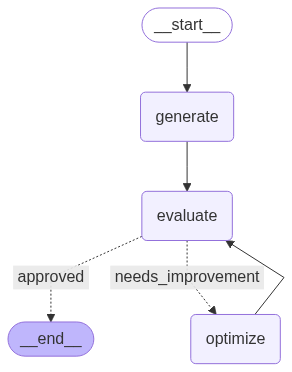

In [121]:
# Compile the graph
workflow = graph.compile()
workflow

In [125]:
initial_state = {"topic": "Corporate",
                 "iteration": 1,
                 "max_iteration": 5
                 }
final_state = workflow.invoke(initial_state)
final_state

{'topic': 'Corporate',
 'tweet': 'Just walked into the office and the coffee machine asked for a performance review. ☕️💼 Apparently my espresso skills are ‘below expectations’ while the printer is ‘exceeding throughput goals.’ If only my inbox could get a raise, I’d finally be promoted to ‘Chief Procrastination Officer.’ #CorporateLife #OfficeHumor',
 'evaluation': 'approved',
 'feedback': 'The tweet adheres to all specified rules and best practices for Twitter/X content.',
 'iteration': 1,
 'max_iteration': 5}